# Trading with Mean-Reversion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cvx
import yfinance as yf

In [2]:
tickers_data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers_data.loc[:,'Symbol'] = tickers_data.loc[:,'Symbol'].apply(lambda x:str(x).replace('.', '-' ))
tickers_data.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [3]:
start = '2011-01-01'
end = '2016-01-01'

In [4]:
tickers = yf.Tickers(list(tickers_data.loc[:,'Symbol']))

data = tickers.history(start=start, end=end, auto_adjust=False, interval='1d')
data = data.stack(level=1).rename_axis(['Date', 'Ticker']).reset_index(level=1)
data['Date'] = data.index
data = data.reset_index(drop=True)
data.head()

[*********************100%%**********************]  503 of 503 completed


20 Failed downloads:
['IR', 'CDAY', 'CTVA', 'OTIS', 'FTV', 'FOXA', 'UBER', 'ABNB', 'MRNA', 'FOX', 'DOW', 'GEHC', 'VLTO', 'HWM', 'LW', 'CEG', 'VICI', 'CARR', 'KVUE', 'INVH']: Exception("%ticker%: Data doesn't exist for startDate = 1293858000, endDate = 1451624400")


,Ticker,Adj Close,Close,Dividends,High,Low,Open,Stock Splits,Volume,Date
0,A,27.013275,29.957083,0.0,30.143063,29.620888,29.728184,0.0,4994075.0,2011-01-03
1,AAL,10.040194,10.650000,0.0,10.710000,10.080000,10.110000,0.0,7465800.0,2011-01-03
2,AAPL,9.977494,11.770357,0.0,11.795000,11.601429,11.630000,0.0,445138400.0,2011-01-03
3,ABT,17.371452,22.944036,0.0,23.169542,22.920046,23.169542,0.0,19050229.0,2011-01-03
4,ACGL,9.832222,9.832222,0.0,9.855556,9.778889,9.855556,0.0,4016700.0,2011-01-03


In [5]:
_open = data.pivot(index='Date', columns='Ticker', values='Open')
_open = _open.dropna(axis=1)
_open.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,29.728184,10.11,11.630000,23.169542,9.855556,48.660000,30.830000,37.680000,30.389999,41.044777,...,92.000000,19.209999,106.250000,23.670000,73.720001,34.459999,35.442127,52.524273,38.270000,24.740000
2011-01-04,30.035765,10.73,11.872857,23.049591,9.860000,48.750000,31.280001,38.200001,30.440001,41.229149,...,92.344368,19.900000,109.410004,23.610001,74.709999,35.070000,35.283970,53.359222,38.480000,25.250000
2011-01-05,29.513592,10.74,11.769643,23.135956,9.736667,48.139999,31.480000,37.430000,30.500000,41.150131,...,91.311256,19.500000,111.550003,23.590000,74.669998,34.639999,34.601006,52.407768,37.639999,24.309999
2011-01-06,29.592276,11.15,11.954286,23.270300,9.642222,48.180000,32.130001,37.750000,31.070000,41.738365,...,92.768211,20.219999,113.919998,23.350000,74.900002,34.930000,35.190510,52.446602,37.880001,24.830000
2011-01-07,29.699572,11.20,11.928214,23.097572,9.652222,48.369999,32.180000,37.939999,31.950001,41.922737,...,93.059601,20.190001,115.660004,23.520000,75.209999,34.950001,35.233646,51.213593,37.470001,24.889999


In [6]:
_adj_close = data.pivot(index='Date', columns='Ticker', values='Adj Close')
_adj_close = _adj_close.dropna(axis=1)
_adj_close.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,27.013275,10.040194,9.977494,17.371452,9.832222,38.189995,31.290001,27.901512,21.699986,30.504303,...,72.243683,12.183898,77.028114,15.394324,44.966919,31.863138,27.514250,48.349262,38.200001,20.047049
2011-01-04,26.761709,10.011912,10.029565,17.534924,9.771111,37.938484,31.510000,27.585369,21.685709,30.394100,...,71.031395,12.054417,79.431038,15.459661,45.178024,31.509119,27.093889,47.707191,37.840000,19.720497
2011-01-05,26.703665,10.464428,10.111609,17.534924,9.785556,37.946346,32.220001,27.644201,21.785637,30.880335,...,72.017670,12.430536,80.455849,15.368187,45.057373,31.808676,27.222797,47.742378,37.799999,19.831993
2011-01-06,26.755268,10.596412,10.103436,17.498592,9.653333,38.087814,32.270000,27.798590,22.620804,31.120232,...,72.223122,12.344214,81.042435,15.355113,45.346924,31.627140,27.413374,46.264709,37.480000,19.776249
2011-01-07,26.845568,10.747252,10.175787,17.571249,9.580000,38.150703,32.040001,27.636831,22.806400,31.191540,...,72.099861,12.683344,83.911827,15.492331,45.594204,31.500048,27.755266,46.255928,37.599998,19.569164


-----

In [6]:
tickers.tickers['AAPL'].info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

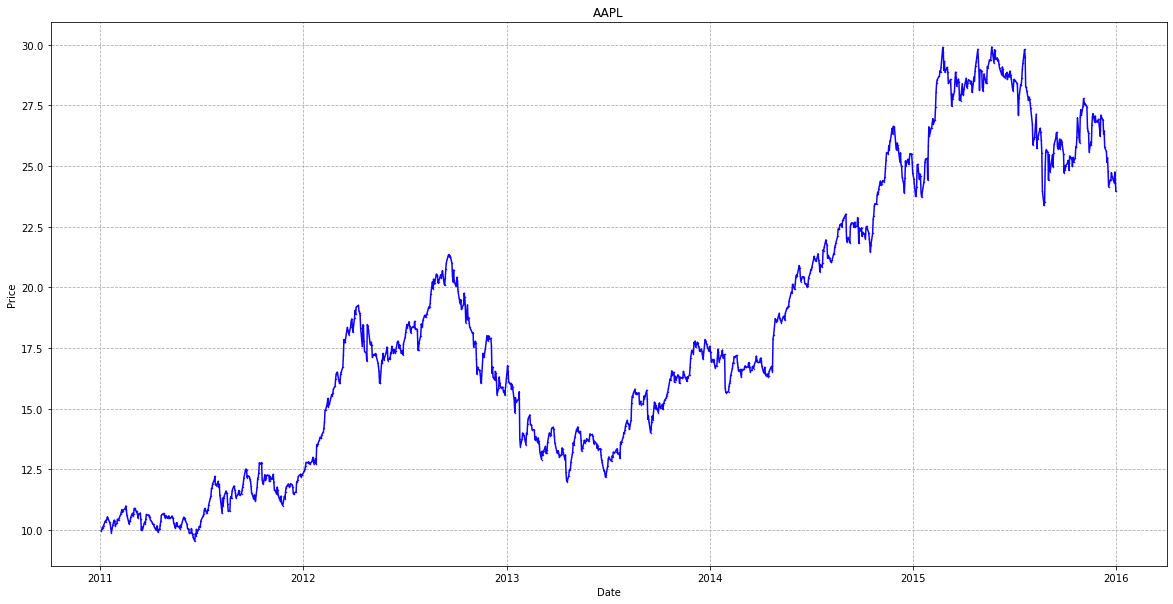

In [13]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('AAPL')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.plot(_adj_close.index, _adj_close.loc[:,['AAPL']].values, marker='.', color='#0F00FF', markersize=1, linestyle='-')

-----

In [14]:
returns = ((_adj_close - _adj_close.shift(1))/_adj_close.shift(1)).iloc[1:,:]
returns.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,-0.009313,-0.002817,0.005219,0.009410,-0.006215,-0.006586,0.007031,-0.011331,-0.000658,-0.003613,...,-0.016781,-0.010627,0.031195,0.004244,0.004695,-0.011111,-0.015278,-0.013280,-0.009424,-0.016289
2011-01-05,-0.002169,0.045198,0.008180,0.000000,0.001478,0.000207,0.022533,0.002133,0.004608,0.015998,...,0.013885,0.031202,0.012902,-0.005917,-0.002671,0.009507,0.004758,0.000738,-0.001057,0.005654
2011-01-06,0.001932,0.012613,-0.000808,-0.002072,-0.013512,0.003728,0.001552,0.005585,0.038336,0.007769,...,0.002853,-0.006944,0.007291,-0.000851,0.006426,-0.005707,0.007001,-0.030951,-0.008466,-0.002811
2011-01-07,0.003375,0.014235,0.007161,0.004152,-0.007597,0.001651,-0.007127,-0.005819,0.008205,0.002291,...,-0.001707,0.027473,0.035406,0.008936,0.005453,-0.004018,0.012472,-0.000190,0.003202,-0.010471
2011-01-10,0.014416,0.006140,0.018833,-0.008889,-0.003363,-0.008859,0.028714,0.002926,0.004382,0.000416,...,0.002565,0.011181,-0.000253,-0.006326,-0.006085,0.010375,0.001414,0.007796,0.002926,-0.017908


-----

In [15]:
def mean_reversion(signals, window_length):
    return -((signals - signals.shift(window_length))/signals.shift(window_length)).iloc[window_length:,:]

def rank(signals, top, bottom):
    filtered_signals = pd.DataFrame(np.zeros(shape=signals.shape))
    filtered_signals = filtered_signals.set_index(signals.index)
    filtered_signals.columns = signals.columns
    for i in range(signals.shape[0]):
        series = signals.iloc[i,:] 
        top_largest = series.nlargest(top)         
        bottom_smallest = series.nsmallest(bottom)         
        ranking = pd.concat([top_largest, bottom_smallest])
        tickers = ranking.index
        filtered_signals.iloc[i,:].loc[tickers] = 1.          
    return filtered_signals

def frequency(signals, freq):
    filtered_signals = pd.DataFrame(np.zeros(shape=signals.shape))
    filtered_signals = filtered_signals.set_index(signals.index)
    filtered_signals.columns = signals.columns
    for i in range(signals.shape[0]):
        if i%freq==0:
            filtered_signals.iloc[i,:] = signals.iloc[i,:] 
        else:
            filtered_signals.iloc[i,:] = np.array(filtered_signals.shape[1]*[np.nan])
    filtered_signals = filtered_signals.dropna(axis=0)
    return filtered_signals

In [16]:
window_length = 5 

signals = mean_reversion(signals=_adj_close, 
                         window_length=window_length)
signals.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-10,-0.008118,-0.076996,-0.039081,-0.002510,0.028930,0.009879,-0.053372,0.006588,-0.055592,-0.022954,...,-0.000569,-0.052631,-0.089091,-0.000000,-0.007780,0.001139,-0.010186,0.035838,0.012827,0.041320
2011-01-11,-0.034948,-0.032957,-0.031242,0.008908,0.005344,-0.010358,-0.046652,-0.013592,-0.060237,-0.031356,...,-0.013017,-0.080819,-0.041819,0.007608,-0.010547,-0.017574,-0.019239,-0.011984,-0.017706,0.018174
2011-01-12,-0.041787,0.019819,-0.031197,0.005144,0.001136,-0.033347,-0.041899,-0.011702,-0.066842,-0.028344,...,-0.003138,-0.068948,-0.025826,-0.000850,-0.025167,-0.035388,-0.017102,-0.026161,-0.019841,0.035341
2011-01-13,-0.035921,0.031139,-0.035807,0.007479,-0.008402,-0.029096,-0.034397,-0.001058,-0.048595,-0.010625,...,0.004552,-0.065934,-0.017877,0.002127,-0.020351,-0.041906,-0.004894,-0.053992,-0.034952,0.041482
2011-01-14,-0.039404,0.053509,-0.036773,0.021599,-0.020877,-0.030078,-0.054619,-0.026869,-0.048826,-0.013303,...,-0.011969,-0.051531,-0.000758,0.010122,-0.029766,-0.045822,0.028999,-0.060467,-0.028457,-0.000814


In [17]:
top = 10
bottom = 10 
signals = rank(signals=signals, 
               top=top, 
               bottom=bottom)
signals.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
freq = 10
signals = frequency(signals=signals, 
                    freq=freq)
signals.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-23,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-09,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-----

In [19]:
def optimal_portfolio(u, V, x0, risk_tolerance, turnover):
    x = cvx.Variable(u.shape[0])
    f = cvx.quad_form(x, V) - risk_tolerance*u@x + turnover*cvx.norm(x-x0, p=1) 
    prob = cvx.Problem(cvx.Minimize(f), 
                      [cvx.sum(x) == 1])
    prob.solve(solver=cvx.ECOS)
    return x.value

In [20]:
def trading_strategy(signals, returns, trading_window_length, risk_tolerance, turnover):
    portfolio_positions = pd.DataFrame(np.zeros(shape=signals.shape))
    portfolio_positions = portfolio_positions.set_index(signals.index)
    portfolio_positions.columns = signals.columns
    for i in range(signals.shape[0]):
        date = signals.index[i]
        tickers = signals.iloc[i,:].apply(lambda x:np.nan if x==0. else x).dropna().index            
        r = returns.loc[:date,:].iloc[-trading_window_length:,:].loc[:,tickers].values
        u = np.mean(r, axis=0)
        V = np.cov(r.T)  
        if i==0:
            x0 = np.ones(tickers.shape[0])/tickers.shape[0]
        else:
            x0 = portfolio_positions.iloc[i-1,:].loc[tickers].values
        x = optimal_portfolio(u, V, x0, risk_tolerance, turnover)
        if x is not None:
            portfolio_positions.loc[date,tickers] = x
        else:
            portfolio_positions.loc[date,:] = np.array(portfolio_positions.shape[1]*[np.nan])
    portfolio_positions = portfolio_positions.dropna(axis=0)
    return portfolio_positions

In [21]:
trading_window_length = 30
risk_tolerance = 0.000001
turnover = 1.

portfolio_positions = trading_strategy(signals=signals, 
                                       returns=returns, 
                                       trading_window_length=trading_window_length,
                                       risk_tolerance=risk_tolerance,
                                       turnover=turnover)
portfolio_positions.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-10,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-25,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000001,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-08,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-23,0.000000e+00,0.032058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-09,2.058292e-07,0.032058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
portfolio_positions.shape[0], np.sum(portfolio_positions.values)

(126, 126.00000000000684)

-----

In [23]:
trading_prices = _open.shift(-1).loc[portfolio_positions.index,:]
trading_prices.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-10,30.414879,11.37,12.317143,23.116764,9.600000,48.169998,33.130001,37.740002,32.220001,42.309044,...,93.377480,20.850000,119.750000,23.620001,75.019997,35.169998,35.909416,52.281551,37.820000,24.360001
2011-01-25,30.629471,10.56,12.248571,23.102369,9.977778,51.630001,33.360001,39.020000,33.730000,43.582088,...,97.192055,23.070000,115.699997,24.070000,78.709999,35.910000,34.615383,54.805824,38.700001,23.549999
2011-02-08,31.480686,9.95,12.685357,21.811708,10.072222,52.310001,33.470001,39.509998,36.180000,43.239685,...,99.152321,24.250000,119.559998,23.740000,82.440002,36.450001,35.521210,58.058250,39.939999,25.320000
2011-02-23,28.855509,8.52,12.286429,22.325094,9.734444,51.270000,33.349998,39.130001,35.950001,43.028973,...,101.615891,23.480000,120.120003,23.670000,87.199997,36.180000,35.212078,59.766991,37.480000,23.299999
2011-03-09,32.446350,8.86,12.468571,23.419039,10.002222,51.619999,34.680000,38.130001,36.169998,44.214222,...,100.185432,23.299999,126.550003,24.389999,83.800003,36.900002,37.419125,60.504852,36.320000,23.070000


In [24]:
trading_returns = ((trading_prices - trading_prices.shift(1))/trading_prices.shift(1)).iloc[1:,:]
trading_returns.head()

Ticker,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-25,0.007055,-0.071240,-0.005567,-0.000623,0.039352,0.071829,0.006942,0.033916,0.046865,0.030089,...,0.040851,0.106475,-0.033820,0.019052,0.049187,0.021041,-0.036036,0.048282,0.023268,-0.033251
2011-02-08,0.027791,-0.057765,0.035660,-0.055867,0.009465,0.013171,0.003297,0.012558,0.072636,-0.007857,...,0.020169,0.051149,0.033362,-0.013710,0.047389,0.015038,0.026168,0.059345,0.032041,0.075159
2011-02-23,-0.083390,-0.143719,-0.031448,0.023537,-0.033536,-0.019881,-0.003585,-0.009618,-0.006357,-0.004873,...,0.024846,-0.031753,0.004684,-0.002949,0.057739,-0.007407,-0.008703,0.029431,-0.061592,-0.079779
2011-03-09,0.124442,0.039906,0.014825,0.049001,0.027508,0.006827,0.039880,-0.025556,0.006120,0.027545,...,-0.014077,-0.007666,0.053530,0.030418,-0.038991,0.019901,0.062679,0.012346,-0.030950,-0.009871
2011-03-23,-0.029982,-0.001129,-0.020824,-0.013727,0.052655,-0.021503,-0.085063,0.014162,-0.001659,-0.002383,...,0.047065,0.059657,-0.036033,-0.035670,-0.012172,-0.028726,-0.012488,-0.032895,0.031938,-0.006935


In [25]:
portfolio_returns = np.sum(trading_returns*portfolio_positions.shift(1).iloc[1:,:], axis=1)
portfolio_returns

Date
2011-01-25   -0.000867
2011-02-08    0.007350
2011-02-23   -0.012233
2011-03-09    0.018247
2011-03-23    0.002065
                ...   
2015-10-30    0.036513
2015-11-13   -0.028014
2015-11-30    0.054879
2015-12-14    0.003823
2015-12-29    0.000195
Length: 125, dtype: float64

<AxesSubplot:title={'center':'Portfolio Returns'}, ylabel='Density'>

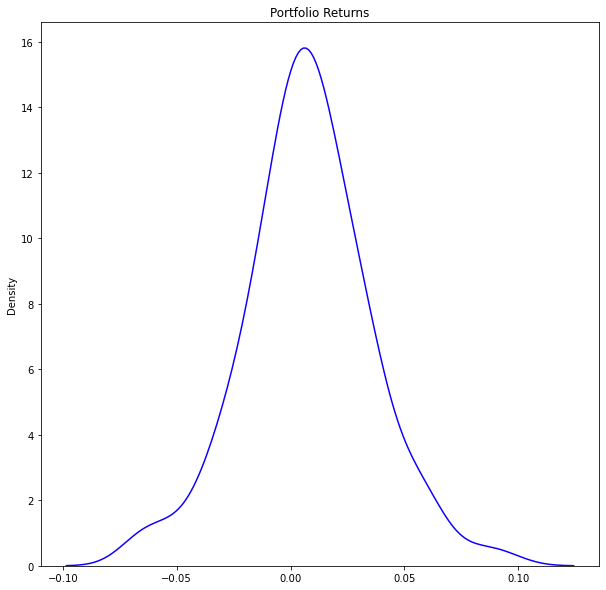

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Portfolio Returns')
sns.kdeplot(data=portfolio_returns, ax=ax, color='#0F00FF')

-----

In [27]:
discount_factor = np.cumprod(portfolio_returns+1)
discount_factor

Date
2011-01-25    0.999133
2011-02-08    1.006476
2011-02-23    0.994164
2011-03-09    1.012305
2011-03-23    1.014395
                ...   
2015-10-30    2.352357
2015-11-13    2.286459
2015-11-30    2.411938
2015-12-14    2.421158
2015-12-29    2.421631
Length: 125, dtype: float64

In [28]:
start = portfolio_positions.index[0]
end = portfolio_positions.index[-1]

In [29]:
market_portfolio_positions = _adj_close.loc[start:end,:].div(_adj_close.loc[start:end,:].sum(axis=1), axis=0)
market_trading_prices = _open.shift(-1).loc[market_portfolio_positions.index,:]
market_trading_returns = ((market_trading_prices - market_trading_prices.shift(1))/market_trading_prices.shift(1)).iloc[1:,:]
market_portfolio_returns = np.sum(market_trading_returns*market_portfolio_positions.shift(1).iloc[1:,:], axis=1)
market_discount_factor = np.cumprod(market_portfolio_returns+1)

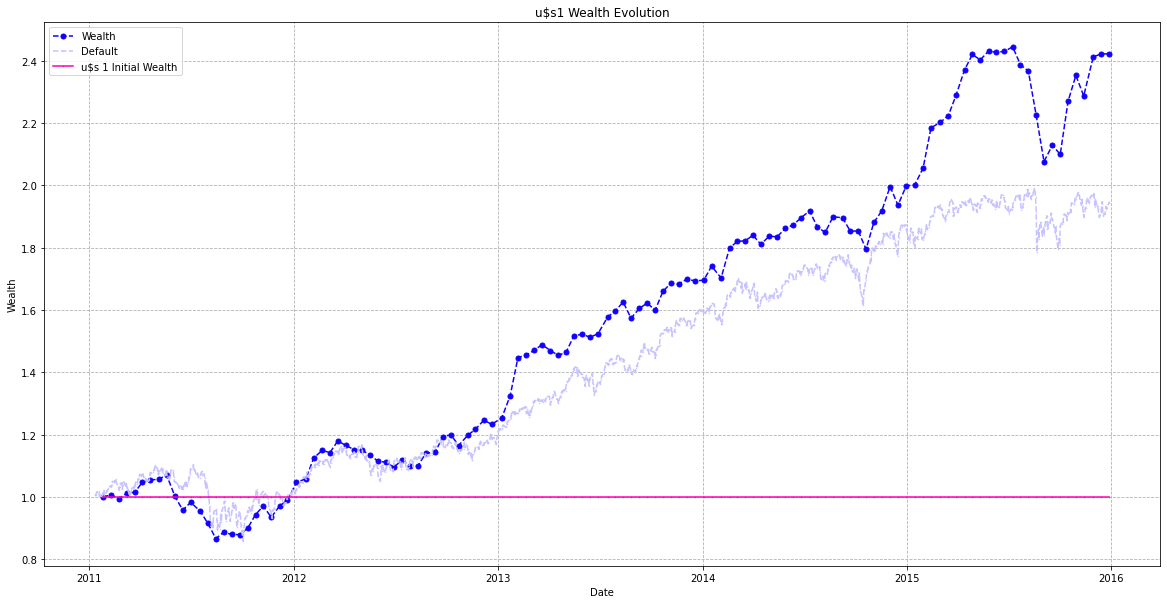

In [30]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('u$s1 Wealth Evolution')
ax.set_xlabel('Date')
ax.set_ylabel('Wealth')
ax.plot(discount_factor.index, discount_factor.values, marker='.', color='#0F00FF', markersize=10, linestyle='--', label='Wealth')
ax.plot(market_discount_factor.index, market_discount_factor.values, marker='.', color='#C7C3FF', markersize=1, linestyle='--', label='Default')
ax.plot(discount_factor.index, np.ones(discount_factor.shape), marker='.', color='#FF00AE', markersize=1, linestyle='-', label='u$s 1 Initial Wealth')
ax.legend()

In [31]:
portfolio_positions.to_csv('meanreversion_trading.csv')

-----

In [32]:
tickers = yf.Ticker("^GSPC")

sp500 = tickers.history(start=start, end=end, auto_adjust=False, interval='1d')
sp500 = sp500.loc[:,['Adj Close']]
sp500.head()

,Adj Close
Date,
2011-01-10 00:00:00-05:00,1269.750000
2011-01-11 00:00:00-05:00,1274.479980
2011-01-12 00:00:00-05:00,1285.959961
2011-01-13 00:00:00-05:00,1283.760010
2011-01-14 00:00:00-05:00,1293.239990


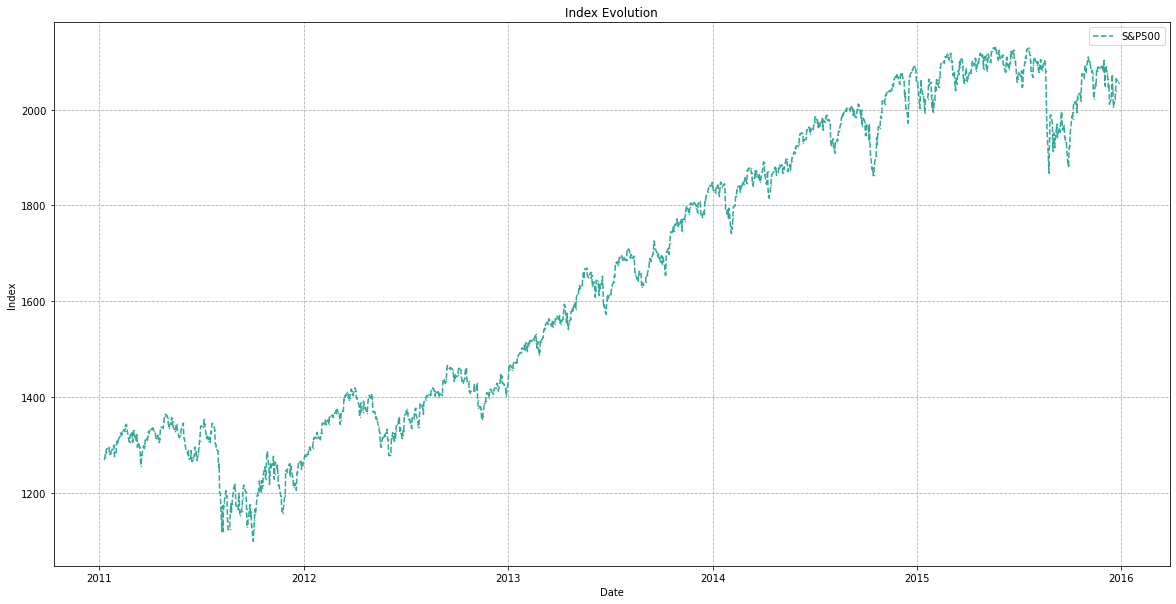

In [33]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.grid(visible=True, linestyle='--')
ax.set_title('Index Evolution')
ax.set_xlabel('Date')
ax.set_ylabel('Index')
ax.plot(sp500.index, sp500.loc[:,'Adj Close'].values, marker='.', color='#32A899', markersize=1, linestyle='--', label='S&P500')
ax.legend()